## 第五章 常用工具
介绍三类工具：  
* 数据处理
* 可视化
* GPU 加速

### 5.1 数据处理
#### 5.1.1 数据加载
**小例子**

In [201]:
%env LS_COLORS = None
!tree --charset ascii data/dogcat/

env: LS_COLORS=None
/bin/sh: tree: command not found


In [202]:
import torch as t
from torch.utils import data

In [203]:
import numpy as np
from PIL import Image
import os

class DogCat1(data.Dataset):
    def __init__(self, root):
        img_names = os.listdir(root)
        self.imgs = [os.path.join(root,img) for img in img_names] # absolute name for each file in root directory
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    

In [204]:
dataset = DogCat1('./data/dogcat/')
img, label = dataset[0]
for img, label in dataset:
    print(img.shape, img.float().mean(), label)

torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([375, 499, 3]) tensor(116.8139) 1
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1


**但是这些结果不适合直接使用。有两个问题：**
* 样本大小不一
* 样本像素值没有归一化

**怎么办？**  
* 用 torchvision.transforms 来解决！

**torchvision 的例子**

In [205]:
from torchvision import transforms as T
import os
import numpy as np
from PIL import Image

transform = T.Compose([
    T.Resize(224),  # 缩放到224
    T.CenterCrop(224), # 从中心切出224大小的块儿
    T.ToTensor(), # 自动归一化
    T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) # 标准化
])

class DogCat(data.Dataset): # 重新写 DogCat，命名不带数字和之前作区分
    def __init__(self, root, transforms = None): # 引入 transforms
        img_names = os.listdir(root)
        self.imgs = [os.path.join(root,img) for img in img_names] # absolute name for each file in the root directory
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        
        if self.transforms:
            data = self.transforms(data) # transform 会把 image 转换成 tensor
        return data, label
    
    def __len__(self):
        return len(self.imgs)
    
dataset = DogCat('data/dogcat', transforms = transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.shape, label)


torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1


**用 ImageFolder 去读取数据**  
ImageFolder 假设所有的文件按文件夹保存，每个文件夹下存储同一个标注的图片。

In [206]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2')

In [207]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [208]:
dataset.imgs

[('data/dogcat_2/cat/cat.12484.jpg', 0),
 ('data/dogcat_2/cat/cat.12485.jpg', 0),
 ('data/dogcat_2/cat/cat.12486.jpg', 0),
 ('data/dogcat_2/cat/cat.12487.jpg', 0),
 ('data/dogcat_2/dog/dog.12496.jpg', 1),
 ('data/dogcat_2/dog/dog.12497.jpg', 1),
 ('data/dogcat_2/dog/dog.12498.jpg', 1),
 ('data/dogcat_2/dog/dog.12499.jpg', 1)]

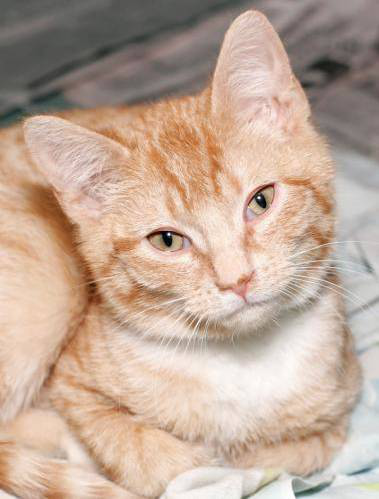

In [209]:
# dataset 里是最原始的 PIL 图片。
dataset[1][0]

In [211]:
# 手动加 transform
normalize = T.Normalize(mean=[.4,.4,.4],std=[.2,.2,.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

torch.Size([3, 224, 224])
tensor(1.8638)
下面就是转换后的效果


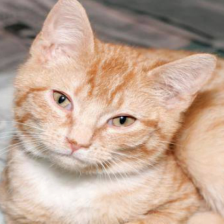

In [213]:
# 重新导入数据集，这次用上 transform
dataset = ImageFolder('data/dogcat_2',transform = transform)

# 查看数据集现在的尺寸
print(dataset[1][0].shape)
print(dataset[1][0].mean())

# 已经标准化。

# 把 tensor 转换回 image
to_img = T.ToPILImage()
print('下面就是转换后的效果')
to_img(dataset[1][0] * .2 + .4)


在上面的代码里我们得到了单个的数据，每个数据都是一张图片。但实际上，神经网络处理的对象是很多数据组成的一批数据，俗称一个 batch。pytorch 也为我们提供了处理 batch 数据的强力工具——DataLoader。
#### DataLoader 的定义
```python
DataLoader(dataset, batch_size = 1, shuffle = False, sampler = None, num_workers = 0, collate_fn = default_collate, pin_memory = False, drop_last = False)
```
* dataset：加载的数据集
* batch_size：这个就是 batch_size 咯
* shuffle：是否将数据打乱
* sampler：样本抽样方法，可以自行定义，稍后会用权重抽样来定义一个
* num_workers：雇用几个工人来干活（使用几个进程）
* collate_fn：如何将样本拼接成一个 batch，选择默认即可
* pin_memory：是否将数据保存在 pin memory 区
* drop_last：dataset 数据个数可能不是 batch_size 的整数倍，如果多出来不足一个 batch 的数据，是否丢弃

In [214]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size = 3, shuffle = True)

#### Dataloader 
* DataLoader 是一个可迭代对象
    ```python
    for batch_data, batch_label in dataloader:
        train()
    ```
    等价于
    ```python
    dataiter = iter(dataloader)
    data, labels = next(dataiter)
    ```
    
* 如果某个样本出错，可以先返回 None，然后在 dataloader 里面实现自定义的 collate_fn，剔除 None 对象。当然最后得到的 batch 个数会小于 batch_size
* 

In [215]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.shape

torch.Size([3, 3, 224, 224])

In [216]:
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            print('wrong')
            return None, None

from torch.utils.data.dataloader import default_collate

def my_collate_fn(batch):
    
    # 在 batch 里面找出所有图像不是 None 的样本
    batch = list(filter(lambda x:x[0] is not None, batch)) # 在 batch 里逐个检查样本图像维是否是 None
    
    # 万一所有样本图像都是 None，返回提示
    if len(batch) == 0: 
        return t.Tensor()
        print('all samples are bad samples...WTF')
    
    # 否则只拼接图像不是 None 的样本
    return default_collate(batch)
    

In [217]:
dataset = NewDogCat('./data/dogcat_wrong', transforms = transform)
dataset[0]

(tensor([[[ 2.5098,  2.4706,  2.3922,  ..., -0.7059, -0.6471, -0.5686],
          [ 2.5098,  2.4706,  2.3922,  ..., -0.6471, -0.5686, -0.5490],
          [ 2.5098,  2.4706,  2.3922,  ..., -0.7059, -0.6275, -0.5882],
          ...,
          [ 1.4314,  1.4706,  1.4706,  ..., -0.8431, -0.8824, -0.9412],
          [ 1.4510,  1.4902,  1.5098,  ..., -0.8235, -0.9412, -0.9804],
          [ 1.4314,  1.4706,  1.5098,  ..., -0.7647, -0.8627, -0.8627]],
 
         [[ 2.2549,  2.2353,  2.1569,  ..., -0.3137, -0.2549, -0.1961],
          [ 2.2549,  2.2353,  2.1569,  ..., -0.2549, -0.1765, -0.1569],
          [ 2.2549,  2.2353,  2.1569,  ..., -0.3333, -0.2549, -0.2353],
          ...,
          [ 1.4314,  1.4706,  1.4706,  ..., -0.4902, -0.5686, -0.6667],
          [ 1.4510,  1.4902,  1.5098,  ..., -0.4902, -0.6078, -0.7059],
          [ 1.4314,  1.4706,  1.5098,  ..., -0.4510, -0.5490, -0.5882]],
 
         [[ 1.5686,  1.4902,  1.3922,  ...,  0.3137,  0.4314,  0.5686],
          [ 1.5686,  1.4902,

In [218]:
dataloader = DataLoader(dataset, 2, collate_fn = my_collate_fn, num_workers = 1, shuffle = True)
for img, label in dataloader:
    print(img.shape,label.shape)

# 成功 debug

wrong
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


一共9张图片，某一个 batch 里有一张坏图，坏图被扔掉了，所以 batch 容量变成2-1=1。4个 batch 里一共8个样本，剩下一个样本不够分，单独成为一个 batch。如果设置 drop_last = True，可以扔掉这个多出来的样本。  

这样对数据进行了全面清洗。虽然结果的 batch_size 减少了，但能够彻底去掉不合格的数据。推荐使用。

#### Sampler  

使用 WeightRandomSampler 可以在样本不均衡时实现权重采样

In [219]:
dataset = DogCat('data/dogcat/', transforms = transform)

# 令取出狗图片的概率是猫的概率的两倍
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

[2, 1, 1, 2, 1, 1, 2, 2]

In [220]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights,       # 每个样本被抽中的概率
                              num_samples = 9,  # 要抽样的样本数是9个
                              replacement = True) # 允许重复抽取某一个样本
dataloader = DataLoader(dataset,
                        batch_size = 3,
                        sampler = sampler)

for data, label in dataloader:
    print(label.tolist())

[0, 0, 1]
[1, 0, 0]
[1, 1, 1]


可见，猫狗样本比例约为 1:2。另外允许了 replacement，所以从8个样本里抽取出了9个样本。  
实际上，如果制定了 sampler，那么 shuffle 参数就被覆盖了从而失效，而且实际返回的样本数量取决于 sampler.num_samples 这个参数。

### 5.2 计算机视觉工具包：torchvision 系统性介绍
torchvision 主要包含三部分：
* models
* datasets
* transforms


#### 下面准备一个预训练的 resnet34 ，把全连接层输出改为10，用来分类 MNIST。

In [ ]:
from torchvision import models
from torch import nn

# 预训练就用了1000个类别。既然要导入预先训练好的网络，那么输出就要设置为和预训练一样，=1000
resnet = models.resnet34(pretrained = True, num_classes = 1000)


In [ ]:
resnet.fc = nn.Linear(512,10)

In [221]:
# 手动加 transform
normalize = T.Normalize(mean=[.4,.4,.4],std=[.2,.2,.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

In [222]:
# 下载 MNIST 数据
from torchvision import datasets

# train = False 获取测试集
dataset = datasets.MNIST('data/', download = True, train = False, transform = transform)

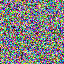

In [223]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3,64,64))

#### 两个常用函数
* make_grid
* save_image

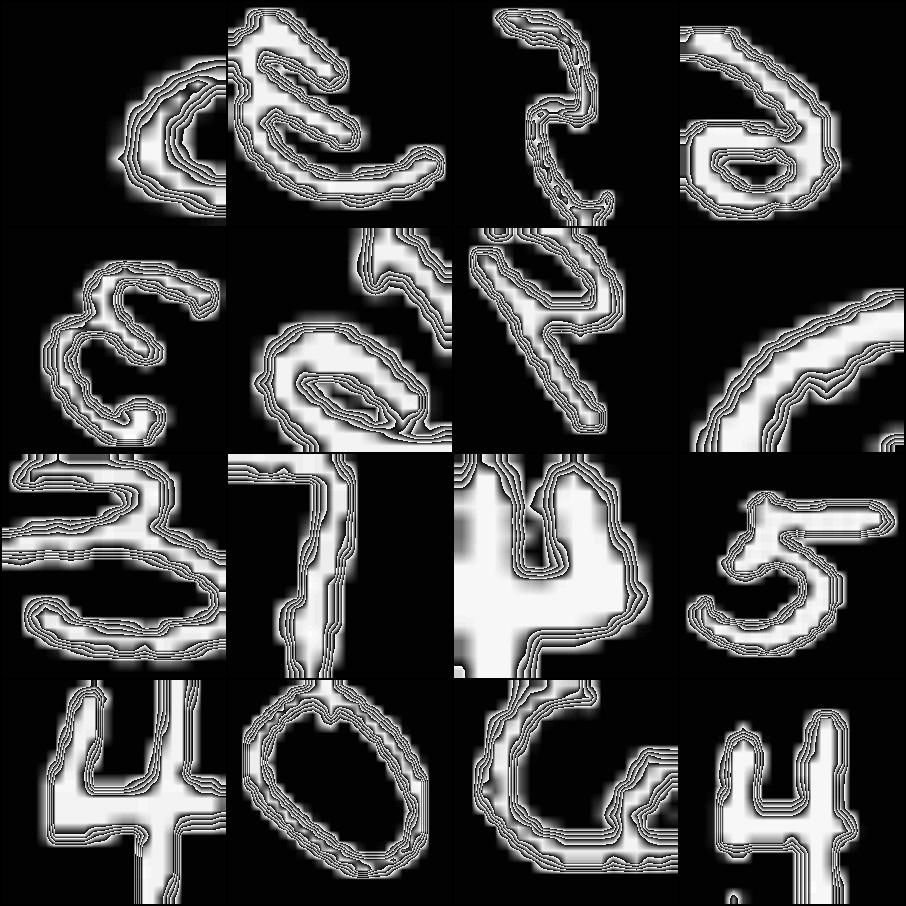

In [227]:
dataloader = DataLoader(dataset, shuffle = True, batch_size = 16)

from torchvision.utils import make_grid, save_image

dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0],4)

# 用上一个 cell 定义出来的函数
to_pil(img)

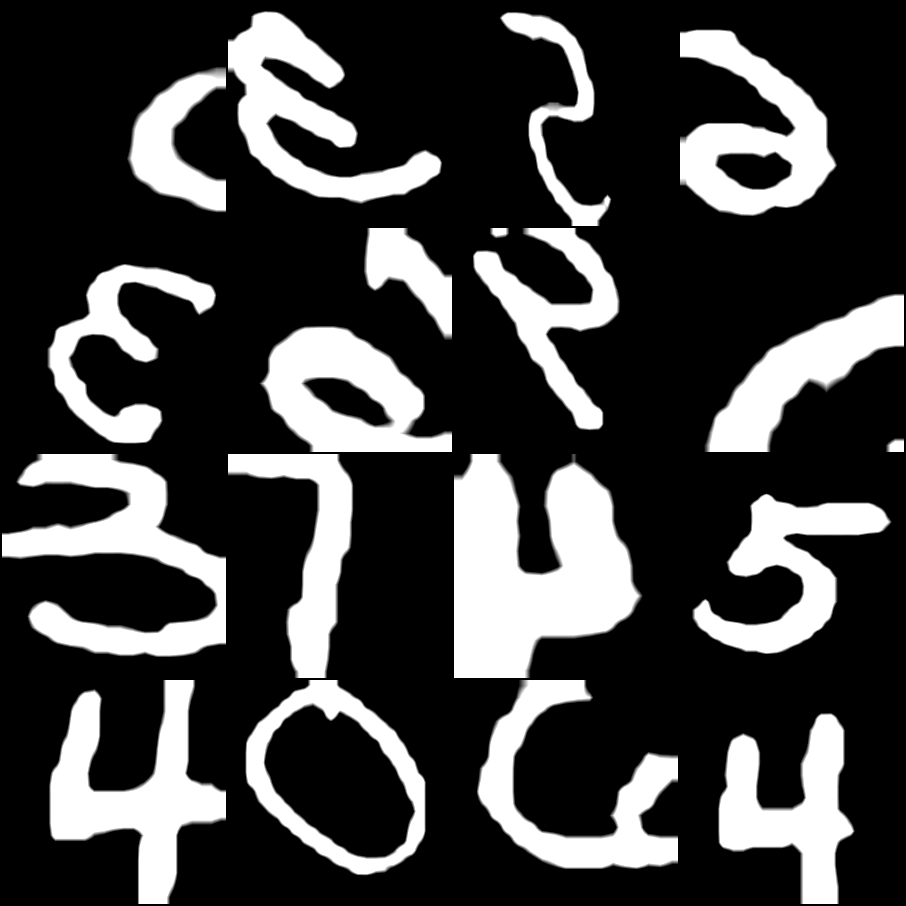

In [228]:
# 保存为图像
save_image(img, 'imgs/mnist_4by4.png')
Image.open('imgs/mnist_4by4.png')

### 5.3 可视化工具
最简单的办法就是打印。但还是不够直观，想看更多，那就需要可视化工具。  
介绍两种：tensorboard 和 visdom
#### 5.3.1 TensorBoard
在 pytorch 中也可以使用 tensorboard，需要安装 tensorboard_logger：
`pip install tensorboard_logger`


In [229]:
from tensorboard_logger import Logger

# 构建 logger 对象
logger = Logger(logdir = 'experimental_cnn/', flush_secs = 2)

In [ ]:
for i in range(100):
    logger.log_value('loss',10-i**0.5, step = i)
    logger.log_value('accuracy', i**0.5/10)

你需要找出 tensorboard 绑定的端口，然后输入 localhost:xxxx 查看。这里就不放结果了。     

还用专门针对 PyTorch 研发的 [**TensorboardX**](https://github.com/lanpa/tensorboard-pytorch)，几乎实现了和 TensorBoard 一样的功能，接口更简单。感兴趣可以查看。  

下面主要介绍 Visdom。

#### 5.3.2 Visdom  
Facebook 专门为 pytorch 开发的可视化工具。  

安装：`pip install visdom`  
启动：`nohup python -m visdom.server`  

Visdom 的两个重要概念：  
* env：环境。不同环境的可视化结果相互隔离，互不影响。默认为 main。
* pane：窗格。用于可视化图像、数值，打印文本等。可以拖动，缩放，保存和关闭。一个程序可以使用一个 env 中的不同 pane，每个 pane 可视化或记录某一种信息。

两个使用要点：
* 需要手动保存 env，重启后消失。
* 客户端与服务器端采用 tornado 非阻塞交互，断网也不会导致程序退出。

In [ ]:
%%sh
nohup python -m visdom.server

In [ ]:
import visdom

vis = visdom.Visdom(env = u'test1')
# 打开 localhost:8097

x = t.arange(1,30,0.01)
y = t.sin(x)
vis.line(X = x, Y = y, win = 'sinx', opts = {'title':'y = sin(x)'})

In [ ]:
vis.image(t.randn(3,64,64).numpy(). win = 'random2')

#### 打开 localhost:8097 只有 visdom 主页面，没有结果？？？
…………

### 5.4 使用 GPU 加速：cuda
本机（MacBook Pro）没有 GPU，本节略。  

#### 一些注意事项：  
并行计算指一机装有多个显卡。指定在哪块 GPU 上运行：
  * Jupyter Notebook: `%env CUDA_VISIBLE_DEVICES = 1,2` # 设置使用第二块和第三块 GPU
  * 程序中: `import os; os.environ['CUDA_VISIBLE_DEVICES'] = 2`

### 5.5 持久化
以下对象可以持久化到硬盘：
* Tensor
* Variable
* nn.Module
* Optimizer

本质都是保存成 tensor。
* 对于 module，主要保存 **state_dict** 而不是整个 module。
* 对于 optimizer，主要保存 parameter 和 **momentum**。

In [192]:
from torchvision.models import SqueezeNet
model = SqueezeNet()
model.state_dict().keys()

/Users/Yang/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/Users/Yang/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


odict_keys(['features.0.weight', 'features.0.bias', 'features.3.squeeze.weight', 'features.3.squeeze.bias', 'features.3.expand1x1.weight', 'features.3.expand1x1.bias', 'features.3.expand3x3.weight', 'features.3.expand3x3.bias', 'features.4.squeeze.weight', 'features.4.squeeze.bias', 'features.4.expand1x1.weight', 'features.4.expand1x1.bias', 'features.4.expand3x3.weight', 'features.4.expand3x3.bias', 'features.5.squeeze.weight', 'features.5.squeeze.bias', 'features.5.expand1x1.weight', 'features.5.expand1x1.bias', 'features.5.expand3x3.weight', 'features.5.expand3x3.bias', 'features.7.squeeze.weight', 'features.7.squeeze.bias', 'features.7.expand1x1.weight', 'features.7.expand1x1.bias', 'features.7.expand3x3.weight', 'features.7.expand3x3.bias', 'features.8.squeeze.weight', 'features.8.squeeze.bias', 'features.8.expand1x1.weight', 'features.8.expand1x1.bias', 'features.8.expand3x3.weight', 'features.8.expand3x3.bias', 'features.9.squeeze.weight', 'features.9.squeeze.bias', 'features.9.

In [193]:
t.save(model.state_dict(), 'saved_models/squeezenet.pth')

In [196]:
from torch import optim
optimizier = optim.Adam(model.parameters(), lr = 0.1)

In [198]:
t.save(optimizier.state_dict(), 'saved_models/adamoptimizer.pth')

In [199]:
all_data = dict(
        optimizier = optimizier.state_dict(),
        model = model.state_dict(),
        info = 'all parameters'
)

t.save(all_data, 'saved_models/all_squeeze_adam.pth')
